In this project is to detect the covid-19 case from the classification of x-ray images such as: Normal, viral pneumonia and COVID-19. In the project, we used the image dataset that can be found at Kaggle: https://www.kaggle.com/amanullahasraf/covid19-pneumonia-normal-chest-xray-pa-dataset

Drawing inspiration from projects on Jovian and other tutorials ( like Skin-Cancer-Classification projects),in this project we divide the data set in order to reserve a validation set of 30 images per class, this will allow the accuracy of the model to be measured during training. Using the ResNet18 network, with pre-trained weights on ImageNet, adjusting only the final classification layer to predict between the 3 classes. I summarize the steps to follow in my project:

1.Download the dataset

2.Preparing Normal, Viral Pneumonia, COVID-19 Dataloader& transforms

3.Model creation

4.Training the Model

5.Testing and evaluation the model

6.Save and Commit

# my-covid-19-detecting-notebook

Use the "Run" button to execute the code.

In [2]:
!pip install jovian --upgrade --quiet

In [3]:
import jovian

In [4]:

jovian.commit(project="my-covid-19-detecting-notebook")

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/younka16-5u9/my-covid-19-detecting-notebook


'https://jovian.ai/younka16-5u9/my-covid-19-detecting-notebook'

Let's begin by installing and importing the required libraries :

In [5]:
import os
import torch
import shutil
import random
import torchvision
import tarfile
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
import warnings
import torchvision.transforms as tt
import matplotlib
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import models
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [6]:
project_name='my-covid-19-detecting'

### **Preparing Normal, Viral Pneumonia, COVID-19 Dataset**

Let's begin by downloading the dataset and creating PyTorch datasets to load the data

# **Download the dataset:**

Let's begin by downloading the dataset from Kaggle

In [7]:
!pip install opendatasets --upgrade --quiet

In [8]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/amanullahasraf/covid19-pneumonia-normal-chest-xray-pa-dataset/download'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: idiryouneskeddar
Your Kaggle Key: ··········


  0%|          | 5.00M/1.91G [00:00<00:55, 36.6MB/s]

100%|██████████| 1.91G/1.91G [00:30<00:00, 67.7MB/s]


In [9]:
# Look into the data directory
data_dir = '/content/covid19-pneumonia-normal-chest-xray-pa-dataset'
print(os.listdir(data_dir))


['covid', 'normal', 'pneumonia']


# **Preparing Normal, Viral Pneumonia, COVID-19 Dataloader& transforms:**

Now we are defining a transformer to Resize the images to 224x224 px and then converting the image to a Tensor.

In [10]:
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.Resize(size=(224,224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

covid_19_dataset = datasets.ImageFolder('/content/covid19-pneumonia-normal-chest-xray-pa-dataset',transform=transform)

in this next step we split the dataset into training, validation and testing sets. We would be using 20% of the data for testing and 10% of the data for validation using :

In [11]:
#we define Hyperparameter 
batch_size = 5
test_size = 0.1
valid_size = 0.1
#test
num_data = len(covid_19_dataset)
indices_data = list(range(num_data))
np.random.shuffle(indices_data)
split_tt = int(np.floor(test_size * num_data))
train_idx, test_idx = indices_data[split_tt:], indices_data[:split_tt]
#Valid
num_train = len(train_idx)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)
split_tv = int(np.floor(valid_size * num_train))
train_new_idx, valid_idx = indices_train[split_tv:],indices_train[:split_tv]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_new_idx)
test_sampler = SubsetRandomSampler(test_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

The next step, we define the DataLoader for training, testing and validation sets.

In [12]:
#DataLoader:
train_loader = torch.utils.data.DataLoader(covid_19_dataset, batch_size=batch_size,sampler=train_sampler, num_workers=1)
valid_loader = torch.utils.data.DataLoader(covid_19_dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(covid_19_dataset, sampler = test_sampler, batch_size=batch_size, num_workers=1)
classes = ['covid','normal',' pneumonia']

Now we can use the train_loader to visualize a few images along with their classes:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


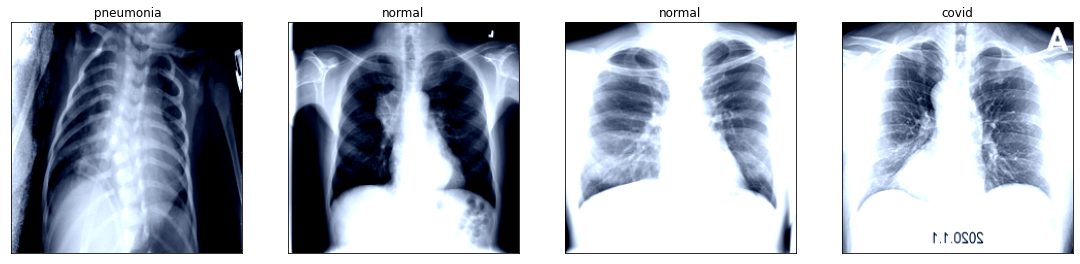

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(24, 12))
# display 20 images
for idx in np.arange(4):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

# **Model creation**:

Next, lets define the model. We will be using a pre-trained Resnet18 architecture for our classification task

In [15]:
import torchvision.models as models
model = models.resnet18(pretrained = True)
train_on_gpu = torch.cuda.is_available()
print(train_on_gpu)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



True


From the data of de conv and resnet18, let’s add fully connected layers at the end of the network, to adjust the final layer output to correspond to the number of classes in our dataset.

In [16]:
for param in model.parameters():
    param.requires_grad = False

from torch import nn
from collections import OrderedDict

fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(512,100)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(100,3)),  # 4 is the number of classes we have in the dataset
    ('output', nn.LogSoftmax(dim=1))
]))

model.fc = fc

In [17]:
model
if train_on_gpu: 
    model.cuda()

In [18]:
import torch.optim as optim
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.fc.parameters(), lr=1e-6)

# **Training the Model**:

Finally, lets train the network for 40

In [19]:
# number of epochs to train the model:
n_epochs = 40
valid_loss_min = np.Inf

for epoch in range(1, n_epochs+1):

    train_loss = 0.0
    valid_loss = 0.0
    
    model.train()
    for data, target in train_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_nbl.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.875753 	Validation Loss: 0.094606
Validation loss decreased (inf --> 0.094606).  Saving model ...
Epoch: 2 	Training Loss: 0.846136 	Validation Loss: 0.090981
Validation loss decreased (0.094606 --> 0.090981).  Saving model ...
Epoch: 3 	Training Loss: 0.825226 	Validation Loss: 0.087826
Validation loss decreased (0.090981 --> 0.087826).  Saving model ...
Epoch: 4 	Training Loss: 0.804746 	Validation Loss: 0.085458
Validation loss decreased (0.087826 --> 0.085458).  Saving model ...
Epoch: 5 	Training Loss: 0.781959 	Validation Loss: 0.085199
Validation loss decreased (0.085458 --> 0.085199).  Saving model ...
Epoch: 6 	Training Loss: 0.767035 	Validation Loss: 0.080620
Validation loss decreased (0.085199 --> 0.080620).  Saving model ...
Epoch: 7 	Training Loss: 0.751249 	Validation Loss: 0.079546
Validation loss decreased (0.080620 --> 0.079546).  Saving model ...
Epoch: 8 	Training Loss: 0.734242 	Validation Loss: 0.076679
Validation loss decreased (0.07954

# **Testing and evaluation the model**:

Now let's evaluate the performance of the network by predicting the classes for test dataset. ets evaluate the performance of the network by predicting the classes for test dataset.

In [20]:
test_loss = 0.0
class_correct = list(0. for i in range(3))
class_total = list(0. for i in range(3))

model.eval()
i=1
# iterate over test data
len(test_loader)
for data, target in test_loader:
    i=i+1
    if len(target)!=batch_size:
        continue
        
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
#     print(target)
    
    for i in range(batch_size):       
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(3):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.051022

Test Accuracy of covid: 88% (199/225)
Test Accuracy of normal: 83% (173/207)
Test Accuracy of  pneumonia: 88% (229/258)

Test Accuracy (Overall): 87% (601/690)


In [21]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian
jovian.commit(project="my-covid-19-detecting-notebook")

To conclude by following this training on Jovain, I have acquired a lot of knowledge about AI (Deep Learning with Pytorch) and its applications in information processing and especially images, for this I would like to invite all readers to follow it and share it. I would also like to congratulate all the person in charge of this training and I invite them to contribute more in this area.